# Implementing batch input function for loading dataset from local TFRecords, the batch can be used for training and testing based on the batch size

In [1]:
import threading
import numpy as np
import tensorflow as tf

def read_and_decode_single_example(filename):
  # Construct the filename queue
  filename_queue = tf.train.string_input_producer(filename, num_epochs=None, shuffle=True)
  # declare the reader
  reader = tf.TFRecordReader()
  # Reader read the file from file_queue
  _,serialized_example = reader.read(filename_queue)
  # decode the TFRecords file based on defined features in protocol buffer
  features = tf.parse_single_example(
    serialized_example,
    features = {
      'image/encoded': tf.FixedLenFeature([], tf.string), # image decoding
      'image/class/label': tf.FixedLenFeature([], dtype=tf.int64,# label decoding as integer, then be convert to float later
                                              default_value=1)
        })
  image = tf.image.decode_jpeg(features['image/encoded'],ratio=4, channels=3,)
  image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
  image.set_shape([480/4,640/4,3]) #has to set the size of the image tensor
  label = tf.cast(features['image/class/label'], tf.float32)
  label = label /100000
  return image,label


def train_batch_input(filenames, batchSize=10, num_preprocess_threads=4, min_queue_size=1024):
# batchSize = 10
  img_width = 480/4
  img_height = 640/4
  img_channel = 3
#   filenames = tf.train.match_filenames_once("train_data/*", name=None)
  image,label = read_and_decode_single_example(filenames)

  image_batch, label_batch = tf.train.shuffle_batch(
    [image, label],
    batch_size=batchSize,
    num_threads=num_preprocess_threads,
    capacity=min_queue_size + 3 * batchSize,
    min_after_dequeue=min_queue_size)
  return image_batch, label_batch

# define parameters here
global trainBatchSize
global num_preprocess_threads
global min_queue_size
trainBatchSize = 128
num_preprocess_threads=6
min_queue_size=2000

filenames = tf.train.match_filenames_once("train_data/*", name=None)

single_image, single_label = read_and_decode_single_example(filenames)

image_batch,label_batch = train_batch_input(filenames, batchSize=trainBatchSize,
                                      num_preprocess_threads=num_preprocess_threads, 
                                      min_queue_size=min_queue_size)

## Building the Neural Network

In [2]:
import tensorflow as tf
import numpy as np


def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})

#     Y = tf.expand_dims(tf.cast(tf.argmax(v_ys,1), tf.float32),1)

    result1 = sess.run(error, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
#     result2 = sess.run(Y, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result1

def evaluate(v_xs):
    predictedVal = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    return predictedVal

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d2(x, W): # stride 2x2
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='VALID')

def conv2d0(x, W): # no stride
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x): # Not needed
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 120, 160, 3]) # 120 x 160 x 3
ys = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)

# udacity image size : 120 x 160 x 3

## need to add normalization here

## conv1 layer ##
W_conv1 = weight_variable([5,5,3,24]) # patch 5x5, stride 2, in size 1, out size 32
b_conv1 = bias_variable([24])
h_conv1 = tf.nn.relu(conv2d2(xs, W_conv1) + b_conv1) # feature map @ layer 1 size 31x98 -> 58x78 (even/2-2)

## conv2 layer ##
W_conv2 = weight_variable([5,5, 24, 36]) # patch 5x5, stride 2, in size 24, out size 36
b_conv2 = bias_variable([36])
h_conv2 = tf.nn.relu(conv2d2(h_conv1, W_conv2) + b_conv2) # feature map @ layer 2 size 14x47 -> 27x37 (odd + 1)/2-2

## conv3 layer 
W_conv3 = weight_variable([5,5, 36, 48]) # patch 5x5, stride 2, in size 36, out size 48
b_conv3 = bias_variable([48])
h_conv3 = tf.nn.relu(conv2d2(h_conv2, W_conv3) + b_conv3) # feature map @ layer 3 size 5x22 -> 12x17

## conv4 layer 
W_conv4 = weight_variable([3,3, 48, 64]) # patch 3x3, stdie 1, in size 48, out size 64
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(conv2d0(h_conv3, W_conv4) + b_conv4) # feature map @ layer 4 size 3x20 -> 10x15

## conv5 layer 
W_conv5 = weight_variable([3,3, 64, 64]) # patch 3x3, stride 1, in size 32, out size 64
b_conv5 = bias_variable([64])
h_conv5 = tf.nn.relu(conv2d0(h_conv4, W_conv5) + b_conv5) # feature map @ layer 5 size 1x18 -> 8x13

## flatten ##
# [n_samples, 1, 18, 64] ->> [n_samples, 1*18*64]
h_conv5_flat = tf.reshape(h_conv5, [-1, 8*13*64])

## fully_connected_layer 1 ##
W_fc1 = weight_variable([8*13*64, 100])
b_fc1 = bias_variable([100])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## fully_connected_layer 2  ##
W_fc2 = weight_variable([100, 50])
b_fc2 = bias_variable([50])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

## fully_connected_layer 3  ##
W_fc3 = weight_variable([50, 10])
b_fc3 = bias_variable([10])
h_fc3 = tf.matmul(h_fc2, W_fc3) + b_fc3

## fully_connected_layer 4  ##
W_fc4 = weight_variable([10, 1])
b_fc4 = bias_variable([1])
prediction = tf.nn.relu(tf.matmul(h_fc3, W_fc4) + b_fc4)


# define the cost and optimizer for optimization, and error is used for evaluation
#===========
# cost = tf.reduce_mean(tf.pow(prediction - ys, 2))
cost = tf.reduce_mean(tf.pow(prediction - ys,2))
# error = tf.reduce_mean(tf.pow(prediction - ys, 2))
error = tf.reduce_mean(tf.pow(prediction - ys,2))
# Gradient descent
train_step = tf.train.AdamOptimizer(1e-3).minimize(cost)
#======



In [3]:
# setup the session
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
threads = tf.train.start_queue_runners(sess=sess)


In [ ]:
# load data one by one, the data will be load sequentially based on which TFRecord file the system chose
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
  img,lab = sess.run([single_image,single_label])
  pl.imshow(img)
  display.clear_output(wait=True)
  display.display(pl.gcf())
  time.sleep(.1)

In [9]:
#load data by batch, because this used tf.train.shuffle_batch, it will load data randomly
# here it shows that one batch of the data is loaded in correct pipeline fashion, the print out shows the speed of loading a batch of 64 images with image size of 480 x 640 x 3

%matplotlib inline
import time
import pylab as pl
from IPython import display


for j in range(10):
  time1 = time.time()
  img,lab = sess.run([image_batch,label_batch])
  print (time.time() - time1,"seconds spend to load one batch")
  print (img.shape)

(0.012352943420410156, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.007704019546508789, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.009739160537719727, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.05491995811462402, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.06052398681640625, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.05533099174499512, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.05418896675109863, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.05017399787902832, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.0562589168548584, 'seconds spend to load one batch')
(128, 120, 160, 3)
(0.05964493751525879, 'seconds spend to load one batch')
(128, 120, 160, 3)


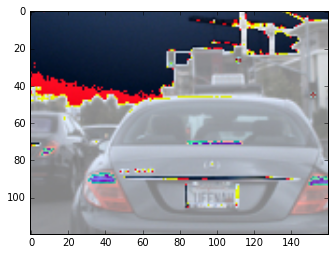

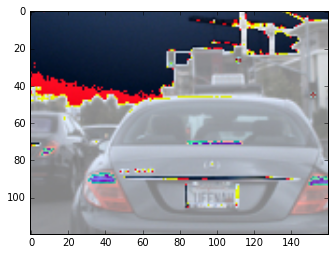

In [5]:
# the plotted image is normalized and casted into float32
%matplotlib inline
import time
import pylab as pl
from IPython import display
# here is an example showing the loaded randomly
for j in range(1):
  img,lab = sess.run([image_batch,label_batch])
#   for i in range(img.shape[0]):
  for i in range(5):
    pl.imshow(img[i,:,:,:])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.1)

In [ ]:
def train(num_iteration):
    for i in range(num_iteration):
#         batch_xs, batch_ys,_ = get_random_batch(batchSize)
#         batch_ys = np.expand_dims(batch_ys, axis=1)
        batch_xs,batch_ys = sess.run([image_batch,label_batch])
        batch_ys = np.expand_dims(batch_ys, axis=1)
        sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.5})
    #     print 'finished training current batch'
        if i % 200 == 0:
            testImg,testLabels = sess.run([image_batch,label_batch])
            testLabels = np.expand_dims(testLabels, axis=1)
            res1 = compute_accuracy(testImg, testLabels)
            print 'accuracy at step',i,':',res1
#             dataInput = testImg[0:1,:,:,:];
#             dataOutput = testLabels[0,:];
#             currResult = evaluate(dataInput)
#             print 'True angle is',dataOutput,'predict angle is',currResult
            
if __name__ == '__main__':
    train(50000)

accuracy at step 0 : 2.28719
accuracy at step 200 : 0.0516949
